「RとStanで始めるベイズ統計モデリングによるデータ分析入門」「実践編第3部第9章 ポアソン回帰モデル」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。

本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです。

# 分析の準備

## パッケージの読み込み

In [1]:
import arviz
import pystan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'
import seaborn as sns

# データの読み込みと図示

## 分析対象のデータ

In [2]:
germination_dat = pd.read_csv('3-9-1-germination.csv')
germination_dat.head(n=3)

,germination,size,solar,nutrition
0,0,10,shade,1
1,0,10,shade,1
2,0,10,shade,1


## データの要約

In [3]:
germination_dat.describe(include='all')

,germination,size,solar,nutrition
count,100.000000,100.0,100,100.000000
unique,NaN,NaN,2,NaN
top,NaN,NaN,shade,NaN
freq,NaN,NaN,50,NaN
mean,2.830000,10.0,NaN,5.500000
std,3.417291,0.0,NaN,2.886751
min,0.000000,10.0,NaN,1.000000
25%,0.000000,10.0,NaN,3.000000
50%,1.000000,10.0,NaN,5.500000
75%,4.000000,10.0,NaN,8.000000


## 図示

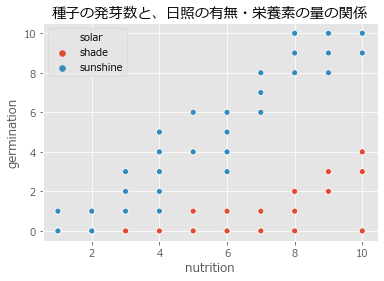

In [4]:
plt.figure()
sns.scatterplot(x='nutrition',
                y='germination',
                data=germination_dat,
                hue='solar')
plt.title('種子の発芽数と、日照の有無・栄養素の量の関係')
plt.show()

# ※省略：brmsによるロジスティック回帰モデルの推定

# brmsを用いない実装の方法
## 参考：ダミー変数の作成

In [5]:
solar_dummy = pd.get_dummies(germination_dat['solar'], drop_first=True)

## 参考：データの作成

In [6]:
data_list_1 = dict(N=len(germination_dat),
                   germination=germination_dat['germination'],
                   binom_size=germination_dat['size'],
                   solar=solar_dummy.values.flatten(),
                   nutrition=germination_dat['nutrition'])
data_list_1

{'N': 100,
 'germination': 0      0
 1      0
 2      0
 3      0
 4      0
       ..
 95     9
 96    10
 97    10
 98     9
 99    10
 Name: germination, Length: 100, dtype: int64,
 'binom_size': 0     10
 1     10
 2     10
 3     10
 4     10
       ..
 95    10
 96    10
 97    10
 98    10
 99    10
 Name: size, Length: 100, dtype: int64,
 'solar': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8),
 'nutrition': 0      1
 1      1
 2      1
 3      1
 4      1
       ..
 95    10
 96    10
 97    10
 98    10
 99    10
 Name: nutrition, Length: 100, dtype: int64}

## 参考：自分でStanコードを実装

In [45]:
# stanコードの記述（3-9-1-glm-binom-1.stan）
stan_code = '''
data {
  int N;                   // サンプルサイズ
  int germination[N];      // 発芽数
  int binom_size[N];       // 二項分布の試行回数
  vector[N] solar;         // 1：日照あり
  vector[N] nutrition;     // 栄養量
}

parameters {
  real Intercept;          // 切片
  real b_solar;            // 係数(日照の有無)
  real b_nutrition;        // 係数(栄養量)
}

model {
  vector[N] prob = Intercept + b_solar*solar + b_nutrition*nutrition;
  germination ~ binomial_logit(binom_size, prob);
}
// 追加：事後予測分布の生成
generated quantities {
    vector[N] prob_solar;        // 日照がある場合の発芽確率
    vector[N] prob_shade;        // 日照がない場合の発芽確率
    vector[N] germination_solar; // 日照がある場合の発芽個数
    vector[N] germination_shade; // 日照がない場合の発芽個数

    for(i in 1:N){
        prob_solar[i] = inv_logit(Intercept +  b_solar*1 + b_nutrition*nutrition[i]);
        prob_shade[i] = inv_logit(Intercept +  b_solar*0 + b_nutrition*nutrition[i]);
        germination_solar[i] = binomial_rng(binom_size[i], prob_solar[i]);
        germination_shade[i] = binomial_rng(binom_size[i], prob_shade[i]);
    }
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
glm_binom_stan = stan_model.sampling(data=data_list_1, seed=1, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_55a63670f6935703a1b875fd847bcc56 NOW.


## 参考：結果の表示

In [8]:
print(glm_binom_stan.stansummary(probs=[0.025, 0.5, 0.975],
                                 pars=['Intercept','b_solar','b_nutrition']))

Inference for Stan model: anon_model_6b1b7a54b53f661f21fcfacd0e907ae0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
Intercept    -8.03    0.02   0.51  -9.09   -8.0  -7.07    701    1.0
b_solar       4.05  9.9e-3   0.29    3.5   4.04   4.64    862    1.0
b_nutrition   0.72  1.9e-3   0.05   0.62   0.72   0.83    814    1.0

Samples were drawn using NUTS at Sat Sep 12 09:20:56 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# 推定されたモデルの解釈

## 係数の解釈

### 説明変数を作る

In [9]:
newdata_1 = np.matrix([[1, 0, 2],
                       [1, 1, 2],
                       [1, 1, 3]])

### 補足：係数行列を作る

In [46]:
# MCMCサンプルの抽出
mcmc_sample = glm_binom_stan.extract()

# 係数行列を作る
newdata_1_b = np.matrix([mcmc_sample['Intercept'],
                         mcmc_sample['b_solar'],
                         mcmc_sample['b_nutrition']])

## 発芽率を予測
### 線形予測氏の予測値

In [11]:
linear_fit = (newdata_1* newdata_1_b).T.mean(axis=0)

### ロジスティック関数を適用して、成功確率を計算

In [12]:
fit = np.ravel(1 / (1 + np.exp(-linear_fit)))
print(fit)

[0.00137892 0.07311323 0.13954887]


## オッズを計算

In [13]:
odds_1 = fit[0] / (1 - fit[0])
odds_2 = fit[1] / (1 - fit[1])
odds_3 = fit[2] / (1 - fit[2])

## モデルの係数を取得

In [14]:
coef = dict(Intercept = mcmc_sample['Intercept'].mean(),
            solarsunshine = mcmc_sample['b_solar'].mean(),
            nutrition = mcmc_sample['b_nutrition'].mean())

## solarがshadeからsunshineに変わった時のオッズ比

In [15]:
print(odds_2 / odds_1)
print(np.exp(coef['solarsunshine']))

57.12545609689797
57.125456096897906


## nutritionが1から2に変わった時のオッズ比

In [16]:
print(odds_3 / odds_2)
print(np.exp(coef['nutrition']))

2.056036551630591
2.056036551630592


## 95%ベイズ信用区間付きの回帰曲線

In [48]:
result_prob_solar = pd.DataFrame(np.zeros([len(germination_dat), 3])) 
result_prob_shade = pd.DataFrame(np.zeros([len(germination_dat), 3])) 

# 2.5・50・97.5パーセンタイルの値をデータフレームに代入
for i in range(len(germination_dat)):
    result_prob_solar.iloc[i,:] = np.percentile(mcmc_sample['prob_solar'][:,i], q=[2.5, 50, 97.5])
    result_prob_shade.iloc[i,:] = np.percentile(mcmc_sample['prob_shade'][:,i], q=[2.5, 50, 97.5])
    
# データフレームの列名を変更
result_prob_solar.columns = ["2.5%", "50%", "97.5%"]
result_prob_shade.columns = ["2.5%", "50%", "97.5%"]

# 温度情報をデータフレームに追加
result_prob_solar['nutrition'] = germination_dat['nutrition']
result_prob_shade['nutrition'] = germination_dat['nutrition']

# 温度情報で並び順をソート
result_prob_solar = result_prob_solar.sort_values('nutrition')
result_prob_shade = result_prob_shade.sort_values('nutrition')

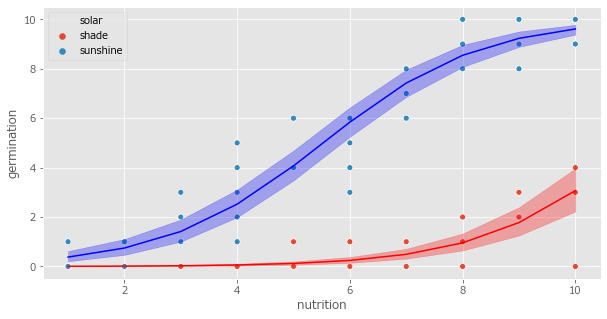

In [49]:
binom_size = 10

# グラフ描画領域の作成
plt.figure(figsize=(10, 5))

# 散布図の描画
sns.scatterplot(x='nutrition',
                y='germination',
                data=germination_dat,
                hue='solar')

# 日照がない日の回帰曲線の描画
plt.plot(result_prob_shade['nutrition'],
         result_prob_shade["50%"]*binom_size,
         color='red')
# 95%ベイズ信頼区間を描画
plt.fill_between(x=result_prob_shade['nutrition'],
                 y1=result_prob_shade["2.5%"]*binom_size,
                 y2=result_prob_shade["97.5%"]*binom_size,
                 color='red',
                 alpha=0.3)

# 日照がある日の回帰曲線の描画
plt.plot(result_prob_solar['nutrition'],
         result_prob_solar["50%"]*binom_size,
         color='blue')
# 95%ベイズ信頼区間を描画
plt.fill_between(x=result_prob_solar['nutrition'],
                 y1=result_prob_solar["2.5%"]*binom_size,
                 y2=result_prob_solar["97.5%"]*binom_size,
                 color='blue',
                 alpha=0.3)

# グラフの描画
plt.show()

In [50]:
result_prob_solar = pd.DataFrame(np.zeros([len(germination_dat), 3])) 
result_prob_shade = pd.DataFrame(np.zeros([len(germination_dat), 3])) 

# 2.5・50・97.5パーセンタイルの値をデータフレームに代入
for i in range(len(germination_dat)):
    result_prob_solar.iloc[i,:] = np.percentile(mcmc_sample['germination_solar'][:,i], q=[2.5, 50, 97.5])
    result_prob_shade.iloc[i,:] = np.percentile(mcmc_sample['germination_shade'][:,i], q=[2.5, 50, 97.5])
    
# データフレームの列名を変更
result_prob_solar.columns = ["2.5%", "50%", "97.5%"]
result_prob_shade.columns = ["2.5%", "50%", "97.5%"]

# 温度情報をデータフレームに追加
result_prob_solar['nutrition'] = germination_dat['nutrition']
result_prob_shade['nutrition'] = germination_dat['nutrition']

# 温度情報で並び順をソート
result_prob_solar = result_prob_solar.sort_values('nutrition')
result_prob_shade = result_prob_shade.sort_values('nutrition')

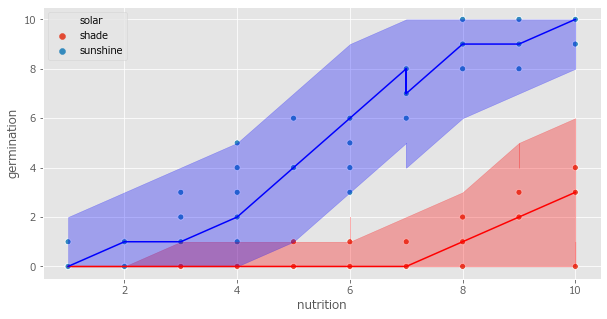

In [51]:
# グラフ描画領域の作成
plt.figure(figsize=(10, 5))

# 散布図の描画
sns.scatterplot(x='nutrition',
                y='germination',
                data=germination_dat,
                hue='solar')

# 日照がない日の回帰曲線の描画
plt.plot(result_prob_shade['nutrition'],
         result_prob_shade["50%"],
         color='red')
# 95%ベイズ信頼区間を描画
plt.fill_between(x=result_prob_shade['nutrition'],
                 y1=result_prob_shade["2.5%"],
                 y2=result_prob_shade["97.5%"],
                 color='red',
                 alpha=0.3)

# 日照がある日の回帰曲線の描画
plt.plot(result_prob_solar['nutrition'],
         result_prob_solar["50%"],
         color='blue')
# 95%ベイズ信頼区間を描画
plt.fill_between(x=result_prob_solar['nutrition'],
                 y1=result_prob_solar["2.5%"],
                 y2=result_prob_solar["97.5%"],
                 color='blue',
                 alpha=0.3)

# グラフの描画
plt.show()